In [ ]:
from keras.callbacks import EarlyStopping,ReduceLROnPlateau,ModelCheckpoint,TensorBoard,LambdaCallback
from keras.layers import Input,Dropout, Dense,GlobalAveragePooling2D
from keras.models import Sequential,Model
from keras.applications.resnet import ResNet50
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from tensorflow import keras
import tensorflow as tf
from tqdm import tqdm
import seaborn as sns
import numpy as np
import itertools 
import datetime

import cv2
import os
import io

In [2]:
#Data Preperation
 
# 1.   Load all training and testing data

# 2.   Pre-processing images (apply opencv functions : bilateralFilter,applyColorMap,resize)

# 3.   Append images and labels into Python list

# 4.   Convert lists into numpy array and normalize images with devide by 255

# 5.   One Hot Encoding on the labels

# 6.   Dividing the dataset into Training and Validation sets

labels = ['glioma', 'meningioma', 'notumor', 'pituitary']

x_train = [] # training images.
y_train  = [] # training labels.
x_test = [] # testing images.
y_test = [] # testing labels.

image_size = 200


for label in labels:
    trainPath = os.path.join(r'C:/Users/HP/Documents/Brain-tumor-detection/Training',label)
    for file in tqdm(os.listdir(trainPath)):
        image = cv2.imread(os.path.join(trainPath, file),0) # load images in gray.
        image = cv2.bilateralFilter(image, 2, 50, 50) # remove images noise.
        image = cv2.applyColorMap(image, cv2.COLORMAP_BONE) # produce a pseudocolored image.
        image = cv2.resize(image, (image_size, image_size)) # resize images into 150*150.
        x_train.append(image)
        y_train.append(labels.index(label))
        testPath = os.path.join(r'C:/Users/HP/Documents/Brain-tumor-detection/Testing',label)
    for file in tqdm(os.listdir(testPath)):
        image = cv2.imread(os.path.join(testPath, file),0)
        image = cv2.bilateralFilter(image, 2, 50, 50)
        image = cv2.applyColorMap(image, cv2.COLORMAP_BONE)
        image = cv2.resize(image, (image_size, image_size))
        x_test.append(image)
        y_test.append(labels.index(label))


x_train = np.array(x_train) / 255.0 # normalize Images into range 0 to 1.
x_test = np.array(x_test) / 255.0

print(x_train.shape)
print(x_test.shape)

100%|███████████████████████████████████████████████████████████████████████████████| 300/300 [00:02<00:00, 101.71it/s]


(5712, 200, 200, 3)
(1311, 200, 200, 3)


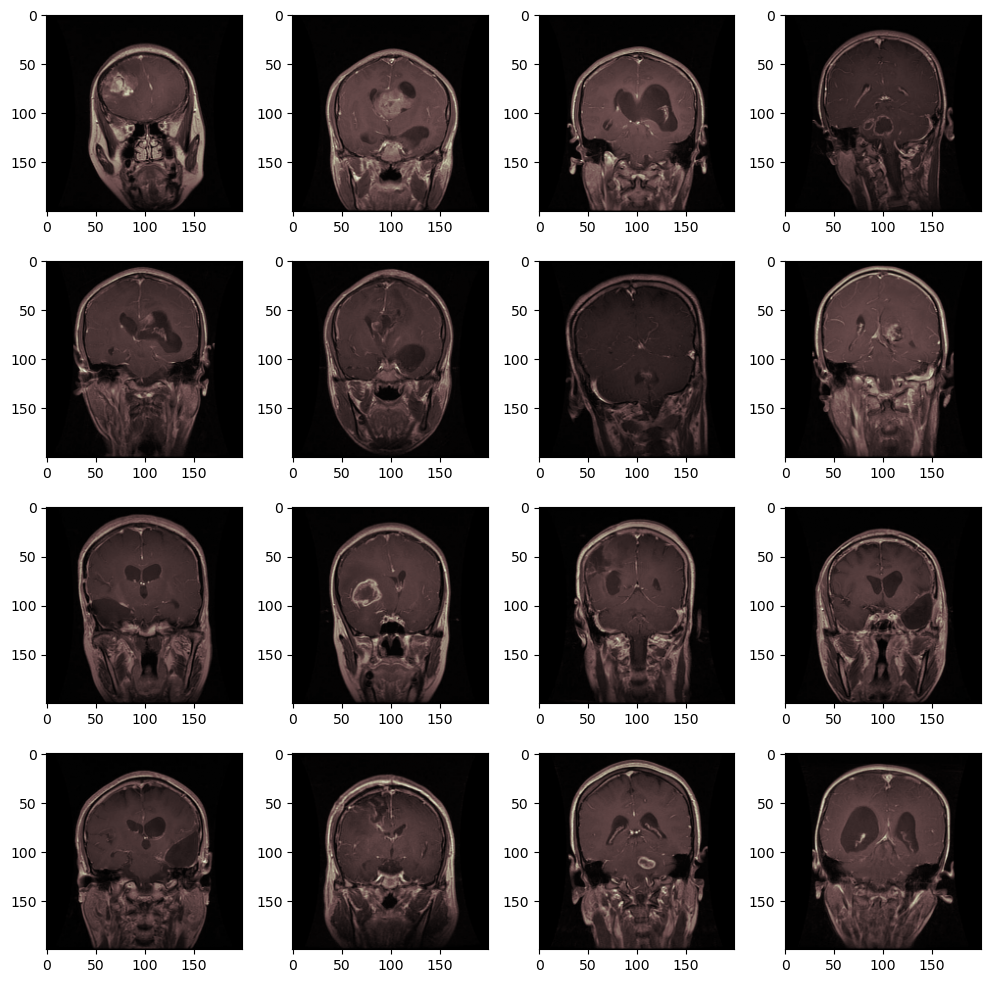

In [3]:
# Select the first 20 images from the 'x_train' dataset and store them in the 'images' list.
images = [x_train[i] for i in range(20)]

# Create a 4x4 grid of subplots (16 subplots in total) with a specified figure size.
fig, axes = plt.subplots(4, 4, figsize=(10, 10))

# Flatten the 4x4 grid of subplots into a 1D array of axes.
axes = axes.flatten()

# For each image and corresponding subplot in the 'images' list and 'axes' array, do the following:
for img, ax in zip(images, axes):
    # Display the image on the current subplot.
    ax.imshow(img)

# Adjust the layout of subplots to ensure they fit well within the figure.
plt.tight_layout()

# Display the entire figure with all the subplots.
plt.show()

In [4]:
x_train, y_train = shuffle(x_train,y_train, random_state=42) 

y_train = tf.keras.utils.to_categorical(y_train) #One Hot Encoding on the labels
y_test = tf.keras.utils.to_categorical(y_test)

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42) #Dividing the dataset into Training and Validation sets.

print(x_val.shape)

(1143, 200, 200, 3)


In [5]:
## Data Augmentation
# In order to make the most of our few training examples, we will **augment** them via a number of random transformations,
# so that our model would never see twice the exact same picture. This helps prevent **overfitting** 
# and helps the model generalize better.
# ImageDataGenerator transforms each image in the batch by a series of random translations, rotations, etc.
datagen = ImageDataGenerator(
    rotation_range=10,                        
    width_shift_range=0.05,
    height_shift_range=0.05,
    horizontal_flip=True)

# After you have created and configured your ImageDataGenerator, you must fit it on your data.
datagen.fit(x_train)

In [6]:
# Big computer brain models that are good at recognizing things in pictures can take a really long time to learn, 
# like several days or even weeks, especially when they are trained on lots of pictures.
# A quicker way to make use of these smart models is to borrow the knowledge they already have. 
# These models have already learned a lot from famous picture tests, like the ImageNet test. 
# The best models are available for download, and you can use them as they are or mix them with
# your own model to solve your own picture problems.
# For this project, I'll be using the ResNet50 model, which comes with knowledge from the ImageNet test.
# Note

# If you set include_top to False, it means you're locking up all the learned stuff in the model so that it doesn't 
# change when you're teaching it new things. This is like freezing a layer in the model: 
# a frozen layer doesn't get updated while teaching.
net = ResNet50(
    weights='imagenet', # Load weights pre-trained on ImageNet.
     include_top=False, # Do not include the ImageNet classifier at the top.
     input_shape=(image_size,image_size,3))

In [7]:
# Get the output of the 'net' model.
model = net.output

# Apply global average pooling to the model's output.
model = GlobalAveragePooling2D()(model)

# Apply dropout with a rate of 0.4 to the model.
model = Dropout(0.4)(model)

# Add a dense (fully connected) layer with 4 output units and softmax activation.
model = Dense(4, activation="softmax")(model)

# Create a new model with 'net' as the input and 'model' as the output.
model = Model(inputs=net.input, outputs=model)

# Compile the model using the Adam optimizer with a learning rate of 0.0001,
# categorical cross-entropy loss, and accuracy as the evaluation metric.
adam = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

# Print a summary of the model's architecture.
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 200, 200, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 206, 206, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 100, 100, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 100, 100, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                          

                                                                                                  
 conv2_block3_1_conv (Conv2  (None, 50, 50, 64)           16448     ['conv2_block2_out[0][0]']    
 D)                                                                                               
                                                                                                  
 conv2_block3_1_bn (BatchNo  (None, 50, 50, 64)           256       ['conv2_block3_1_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv2_block3_1_relu (Activ  (None, 50, 50, 64)           0         ['conv2_block3_1_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv2_blo

 ation)                                                                                           
                                                                                                  
 conv3_block2_3_conv (Conv2  (None, 25, 25, 512)          66048     ['conv3_block2_2_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv3_block2_3_bn (BatchNo  (None, 25, 25, 512)          2048      ['conv3_block2_3_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv3_block2_add (Add)      (None, 25, 25, 512)          0         ['conv3_block1_out[0][0]',    
                                                                     'conv3_block2_3_bn[0][0]']   
          

 conv4_block1_2_conv (Conv2  (None, 13, 13, 256)          590080    ['conv4_block1_1_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv4_block1_2_bn (BatchNo  (None, 13, 13, 256)          1024      ['conv4_block1_2_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv4_block1_2_relu (Activ  (None, 13, 13, 256)          0         ['conv4_block1_2_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv4_block1_0_conv (Conv2  (None, 13, 13, 1024)         525312    ['conv3_block4_out[0][0]']    
 D)       

                                                                                                  
 conv4_block3_out (Activati  (None, 13, 13, 1024)         0         ['conv4_block3_add[0][0]']    
 on)                                                                                              
                                                                                                  
 conv4_block4_1_conv (Conv2  (None, 13, 13, 256)          262400    ['conv4_block3_out[0][0]']    
 D)                                                                                               
                                                                                                  
 conv4_block4_1_bn (BatchNo  (None, 13, 13, 256)          1024      ['conv4_block4_1_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv4_blo

 D)                                                                                               
                                                                                                  
 conv4_block6_3_bn (BatchNo  (None, 13, 13, 1024)         4096      ['conv4_block6_3_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv4_block6_add (Add)      (None, 13, 13, 1024)         0         ['conv4_block5_out[0][0]',    
                                                                     'conv4_block6_3_bn[0][0]']   
                                                                                                  
 conv4_block6_out (Activati  (None, 13, 13, 1024)         0         ['conv4_block6_add[0][0]']    
 on)                                                                                              
          

 conv5_block3_1_relu (Activ  (None, 7, 7, 512)            0         ['conv5_block3_1_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv5_block3_2_conv (Conv2  (None, 7, 7, 512)            2359808   ['conv5_block3_1_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv5_block3_2_bn (BatchNo  (None, 7, 7, 512)            2048      ['conv5_block3_2_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv5_block3_2_relu (Activ  (None, 7, 7, 512)            0         ['conv5_block3_2_bn[0][0]']   
 ation)   